# 03 - Modélisation

**Étapes:**
1. Charger et préparer les données
2. Split train/val/test (60/20/20)
3. Normaliser (StandardScaler)
4. ~~Tuner les hyperparamètres~~ *(commenté - déjà fait)*
5. Entraîner avec les meilleurs paramètres (max_depth=7, min_leaf=1)
6. ~~Learning curves~~ *(commenté - prend du temps)*
7. Évaluer
8. Importance des features
9. Feature selection (test - conclusion: pas utile)
10. Analyse des erreurs
11. Test: Transformation log
12. Test: Features temporelles (lag)

In [ ]:
import sys
sys.path.append('..')

from src.paths import WATER_QUALITY_FILE, LANDSAT_FILE, TERRACLIMATE_FILE
from src.config import TARGETS, ALL_FEATURES
from src.data.load_data import load_all
from src.features import prepare_training, select_model_features
from src.models import split_data, normalize, train_models, evaluate, print_results, get_feature_importance, test_hyperparameters
from src.visualization import plot_predictions, plot_importance, plot_learning_curves, plot_hyperparameter_search

## 1. Charger et préparer les données

In [ ]:
# Charger
_, _, _, df_raw = load_all(
    str(WATER_QUALITY_FILE),
    str(LANDSAT_FILE),
    str(TERRACLIMATE_FILE),
    features=ALL_FEATURES,
    fill_na=False
)

# Préparer (nettoyer + features + encoding)
df_train, medians = prepare_training(df_raw)

CHARGEMENT DES DONNÉES
[OK] Water quality: 9319 lignes
[OK] Landsat: 9319 lignes, 13 colonnes
[OK] TerraClimate: 9319 lignes
[OK] Données fusionnées: 9319 lignes, 26 colonnes

Valeurs manquantes:

10 colonnes avec des valeurs manquantes:
  - blue: 1371 manquants (14.7%)
  - green: 814 manquants (8.7%)
  - red: 1371 manquants (14.7%)
  - nir: 814 manquants (8.7%)
  - swir16: 814 manquants (8.7%)
  - swir22: 814 manquants (8.7%)
  - NDVI: 1371 manquants (14.7%)
  - NDWI: 814 manquants (8.7%)
  - NDMI: 814 manquants (8.7%)
  - MNDWI: 814 manquants (8.7%)
[OK] 162 sites uniques identifiés
[OK] X: 9319 lignes, 20 features
[OK] y: 9319 lignes, 3 targets

PRÊT!
Nettoyage: 9319 -> 7932 lignes


In [ ]:
# Sélectionner X et y
X = select_model_features(df_train)
y = df_train[TARGETS]

feature_names = list(X.columns)
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"\nFeatures: {feature_names}")

X: (7932, 26)
y: (7932, 3)

Features: ['blue', 'green', 'red', 'nir', 'swir16', 'swir22', 'NDVI', 'NDWI', 'NDMI', 'MNDWI', 'pet', 'aet', 'ppt', 'tmax', 'tmin', 'soil', 'def', 'pdsi', 'vpd', 'ws', 'day_of_year', 'nir_green_ratio', 'swir_ratio', 'season_spring', 'season_summer', 'season_winter']


## 2. Split train/val/test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

Train: 4758 | Val: 1587 | Test: 1587


## 3. Normaliser

In [ ]:
X_train_sc, X_val_sc, X_test_sc, scaler = normalize(X_train, X_val, X_test)

## 4. Tuner les hyperparamètres

Objectif : visualiser les courbes R² train/val pour différentes combinaisons de `max_depth` et `min_samples_leaf`.

- **Lignes pleines** = score sur train
- **Lignes pointillées** = score sur validation
- **Gap important** entre train et val = overfitting
- Choisir les paramètres qui maximisent val_R² avec un gap raisonnable

In [ ]:
# === HYPERPARAMETER TUNING (décommenter pour explorer) ===
# Prend du temps, résultats déjà analysés: max_depth=7, min_samples_leaf=1

# results_df = test_hyperparameters(
#     X_train_sc, y_train,
#     X_val_sc, y_val,
#     max_depths=[3, 5, 7, 10],
#     min_samples_leafs=[1, 5, 10, 20]
# )
# plot_hyperparameter_search(results_df)

## 5. Entraîner avec les meilleurs paramètres

In [ ]:
# Meilleurs paramètres (déterminés via hyperparameter tuning)
BEST_MAX_DEPTH = 7
BEST_MIN_SAMPLES_LEAF = 1

# Entraîner avec ces paramètres
models = train_models(
    X_train_sc, y_train,
    n_estimators=100,
    max_depth=BEST_MAX_DEPTH,
    min_samples_leaf=BEST_MIN_SAMPLES_LEAF
)
print(f"Modèles entraînés avec max_depth={BEST_MAX_DEPTH}, min_samples_leaf={BEST_MIN_SAMPLES_LEAF}")

## 6. Learning Curves (vérification)

Vérifier que l'overfitting est réduit avec les nouveaux paramètres.

In [ ]:
# === LEARNING CURVES (décommenter pour vérifier l'overfitting) ===
# Prend du temps (~2-3 min)

# plot_learning_curves(X_train_sc, y_train, n_estimators=100, max_depth=BEST_MAX_DEPTH, cv=5)

## 7. Évaluer

In [ ]:
# Comparer Train vs Validation vs Test
train_results = evaluate(models, X_train_sc, y_train)
val_results = evaluate(models, X_val_sc, y_val)
test_results = evaluate(models, X_test_sc, y_test)

print("Comparaison Train / Validation / Test:")
print("-" * 60)
print(f"{'Target':<35} {'Train':>8} {'Val':>8} {'Test':>8} {'Gap':>8}")
print("-" * 60)
for target in TARGETS:
    tr = train_results[target]['R2']
    va = val_results[target]['R2']
    te = test_results[target]['R2']
    gap = tr - va
    print(f"{target:<35} {tr:>8.3f} {va:>8.3f} {te:>8.3f} {gap:>8.3f}")

Comparaison Train / Validation / Test:
------------------------------------------------------------
Target                                 Train      Val     Test      Gap
------------------------------------------------------------
Total Alkalinity                       0.406    0.349    0.349    0.057
Electrical Conductance                 0.377    0.311    0.342    0.066
Dissolved Reactive Phosphorus          0.241    0.206    0.182    0.035


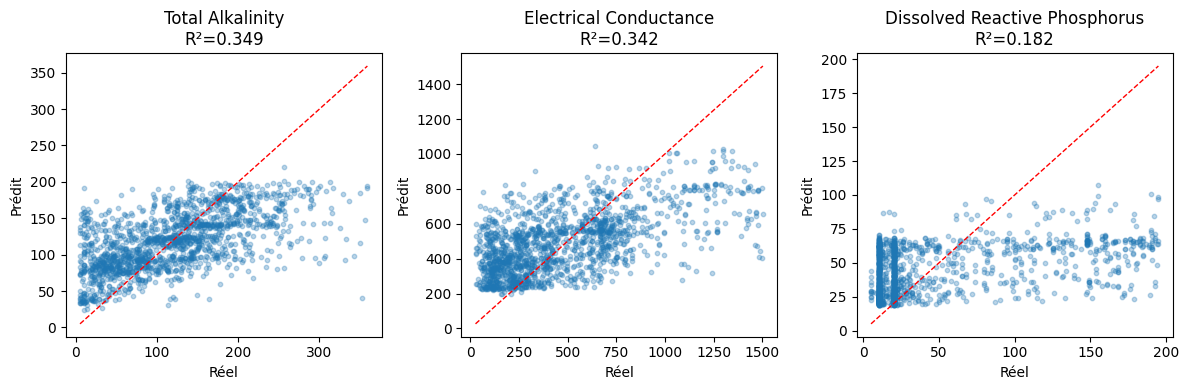

In [ ]:
# Graphiques prédictions vs réalité
plot_predictions(models, X_test_sc, y_test, test_results)

## 8. Importance des features

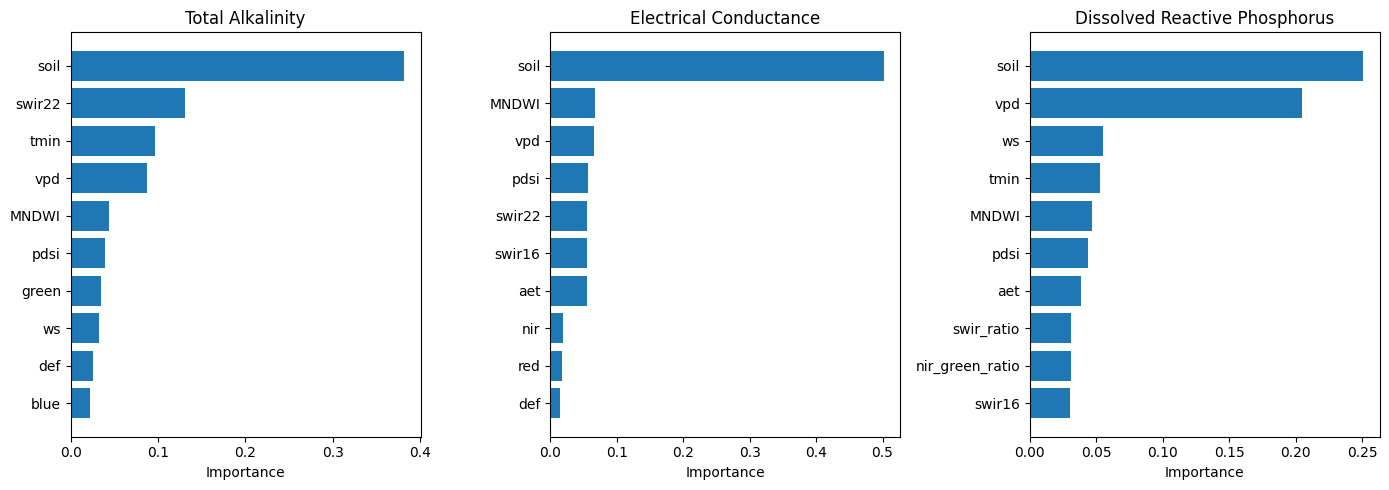

In [ ]:
plot_importance(models, feature_names)

In [ ]:
# Top 10 features par target
importances = get_feature_importance(models, feature_names)
for target, df in importances.items():
    print(f"\n{target}:")
    print(df.to_string(index=False))


Total Alkalinity:
feature  importance
   soil    0.381659
 swir22    0.130655
   tmin    0.097097
    vpd    0.087661
  MNDWI    0.043762
   pdsi    0.039498
  green    0.034229
     ws    0.032581
    def    0.026131
   blue    0.022207

Electrical Conductance:
feature  importance
   soil    0.501779
  MNDWI    0.067475
    vpd    0.065129
   pdsi    0.056124
 swir22    0.055847
 swir16    0.055242
    aet    0.054930
    nir    0.019697
    red    0.017395
    def    0.015067

Dissolved Reactive Phosphorus:
        feature  importance
           soil    0.250971
            vpd    0.204679
             ws    0.054901
           tmin    0.052787
          MNDWI    0.046520
           pdsi    0.044075
            aet    0.038200
     swir_ratio    0.030790
nir_green_ratio    0.030755
         swir16    0.030438


## 9. Feature Selection - Union des top 10

Test : réduire le nombre de features en gardant uniquement l'union des top 10 de chaque target.

**Conclusion** : La feature selection n'améliore pas les résultats. Random Forest gère bien les features peu pertinentes en les ignorant naturellement. On garde donc toutes les features.

In [ ]:
# Calculer l'union des top 10 features de chaque target
selected_features = set()
for target, df in importances.items():
    top_features = df['feature'].tolist()
    selected_features.update(top_features)

selected_features = sorted(list(selected_features))
print(f"Features sélectionnées ({len(selected_features)}):")
print(selected_features)

In [ ]:
# Refaire le split et normalisation avec les features sélectionnées
X_selected = X[selected_features]

X_train_sel, X_val_sel, X_test_sel, y_train, y_val, y_test = split_data(X_selected, y)
X_train_sel_sc, X_val_sel_sc, X_test_sel_sc, scaler_sel = normalize(X_train_sel, X_val_sel, X_test_sel)

In [ ]:
# Entraîner avec les features sélectionnées
models_selected = train_models(
    X_train_sel_sc, y_train,
    n_estimators=100,
    max_depth=BEST_MAX_DEPTH,
    min_samples_leaf=BEST_MIN_SAMPLES_LEAF
)

# Évaluer
train_res_sel = evaluate(models_selected, X_train_sel_sc, y_train)
val_res_sel = evaluate(models_selected, X_val_sel_sc, y_val)
test_res_sel = evaluate(models_selected, X_test_sel_sc, y_test)

# Comparaison avant/après feature selection
print("Comparaison: Toutes features vs Features sélectionnées")
print("=" * 70)
print(f"{'Target':<35} {'All (Test)':>12} {'Selected (Test)':>15} {'Diff':>8}")
print("-" * 70)
for target in TARGETS:
    all_r2 = test_results[target]['R2']
    sel_r2 = test_res_sel[target]['R2']
    diff = sel_r2 - all_r2
    print(f"{target:<35} {all_r2:>12.3f} {sel_r2:>15.3f} {diff:>+8.3f}")

## 10. Analyse des erreurs

Comprendre où et pourquoi le modèle échoue pour identifier les limites et pistes d'amélioration.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculer les prédictions et résidus sur le test set
residuals = {}
predictions = {}

for target in TARGETS:
    y_pred = models[target].predict(X_test_sc)
    y_true = y_test[target].values
    residuals[target] = y_true - y_pred
    predictions[target] = y_pred

# Créer un DataFrame pour l'analyse
df_errors = X_test.copy()
df_errors['site'] = df_train.loc[X_test.index, 'site'] if 'site' in df_train.columns else 'unknown'
for target in TARGETS:
    df_errors[f'{target}_true'] = y_test[target].values
    df_errors[f'{target}_pred'] = predictions[target]
    df_errors[f'{target}_error'] = residuals[target]
    df_errors[f'{target}_abs_error'] = np.abs(residuals[target])

print(f"Analyse sur {len(df_errors)} échantillons du test set")

### 10.1 Distribution des erreurs

**Comment lire ce graphique :**
- L'histogramme montre la répartition des erreurs (réel - prédit)
- **Ligne rouge pointillée** = zéro (erreur nulle)
- **Ligne orange** = moyenne des erreurs

**Ce qu'on cherche :**
- Distribution **centrée sur 0** → le modèle n'a pas de biais systématique ✓
- Distribution **symétrique** → le modèle ne sous/sur-estime pas plus d'un côté
- **Écart-type faible** → erreurs concentrées (bonnes prédictions)
- **Queues longues** → présence d'outliers (cas difficiles)

In [ ]:
# Distribution des erreurs (résidus)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    errors = residuals[target]
    
    ax.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.axvline(x=errors.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {errors.mean():.2f}')
    
    ax.set_xlabel('Erreur (réel - prédit)')
    ax.set_ylabel('Fréquence')
    ax.set_title(f'{target}\nStd: {errors.std():.2f}')
    ax.legend()

plt.suptitle('Distribution des résidus (erreurs)', fontsize=12)
plt.tight_layout()
plt.show()

# Stats des erreurs
print("\nStatistiques des erreurs:")
print("-" * 60)
for target in TARGETS:
    errors = residuals[target]
    print(f"{target}:")
    print(f"  Mean: {errors.mean():.3f} | Std: {errors.std():.3f}")
    print(f"  Min: {errors.min():.3f} | Max: {errors.max():.3f}")
    print(f"  % erreurs > 2*std: {100 * (np.abs(errors) > 2*errors.std()).mean():.1f}%")

### 10.2 Erreurs vs valeurs réelles (Hétéroscédasticité)

**Comment lire ce graphique :**
- Chaque point = un échantillon du test set
- Axe X = valeur réelle de la target
- Axe Y = erreur de prédiction (réel - prédit)
- **Ligne rouge** = erreur zéro (prédiction parfaite)
- **Ligne orange** = tendance moyenne des erreurs

**Ce qu'on cherche :**
- **Points répartis uniformément autour de 0** → modèle stable sur toute la plage ✓
- **Tendance orange qui monte vers la droite** → le modèle **sous-estime** les grandes valeurs
- **Tendance orange qui descend vers la droite** → le modèle **sur-estime** les grandes valeurs
- **Écartement qui augmente aux extrêmes** → hétéroscédasticité (valeurs extrêmes plus difficiles)

**Interprétation typique :**
Si la tendance s'éloigne de 0 aux extrêmes, c'est un signe de "régression vers la moyenne" — le modèle prédit des valeurs moins extrêmes que la réalité.

In [ ]:
# Erreurs vs valeurs réelles (hétéroscédasticité)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    y_true = y_test[target].values
    errors = residuals[target]
    
    ax.scatter(y_true, errors, alpha=0.3, s=10)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    
    # Ligne de tendance (moyenne mobile)
    sorted_idx = np.argsort(y_true)
    window = len(y_true) // 20
    if window > 1:
        from scipy.ndimage import uniform_filter1d
        rolling_mean = uniform_filter1d(errors[sorted_idx], size=window)
        ax.plot(y_true[sorted_idx], rolling_mean, color='orange', linewidth=2, label='Tendance')
    
    ax.set_xlabel('Valeur réelle')
    ax.set_ylabel('Erreur')
    ax.set_title(target)
    ax.legend()

plt.suptitle('Résidus vs Valeurs réelles (hétéroscédasticité)', fontsize=12)
plt.tight_layout()
plt.show()

### 10.3 Erreurs vs features importantes

**Comment lire ce graphique :**
- Axe X = valeur de `soil` (feature la plus importante, ~25-50% d'importance)
- Axe Y = erreur absolue |réel - prédit|
- **Points rouges reliés** = moyenne des erreurs par tranche de `soil`

**Ce qu'on cherche :**
- **Courbe rouge plate** → le modèle prédit aussi bien quel que soit `soil` ✓
- **Courbe rouge qui monte** → le modèle a plus de mal avec certaines valeurs de `soil`
- **Pics locaux** → zones problématiques spécifiques (manque de données ? relation différente ?)

**Interprétation :**
`soil` est la variable climatique la plus importante. Si les erreurs augmentent pour certaines valeurs, ça peut indiquer :
- Peu d'échantillons dans cette plage
- Une relation non-linéaire non capturée
- Un effet d'interaction avec d'autres variables

In [ ]:
# Erreurs vs soil (feature la plus importante)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    soil_values = df_errors['soil'].values
    abs_errors = df_errors[f'{target}_abs_error'].values
    
    ax.scatter(soil_values, abs_errors, alpha=0.3, s=10)
    
    # Binned mean pour voir la tendance
    bins = np.percentile(soil_values, np.linspace(0, 100, 11))
    bin_centers = []
    bin_means = []
    for j in range(len(bins)-1):
        mask = (soil_values >= bins[j]) & (soil_values < bins[j+1])
        if mask.sum() > 0:
            bin_centers.append((bins[j] + bins[j+1]) / 2)
            bin_means.append(abs_errors[mask].mean())
    ax.plot(bin_centers, bin_means, 'ro-', linewidth=2, markersize=8, label='Moyenne par bin')
    
    ax.set_xlabel('soil')
    ax.set_ylabel('|Erreur|')
    ax.set_title(target)
    ax.legend()

plt.suptitle('Erreur absolue vs Soil', fontsize=12)
plt.tight_layout()
plt.show()

### 10.4 Pires prédictions

**Comment lire ce tableau :**
- Les 10 échantillons avec les plus grandes erreurs absolues
- Colonnes : valeur réelle, prédiction, erreur, et features clés

**Ce qu'on cherche :**
- **Patterns communs** : Les outliers ont-ils des valeurs extrêmes de `soil`, `vpd`, etc. ?
- **Valeurs réelles extrêmes** : Le modèle échoue-t-il sur les cas rares ?
- **Erreurs de données** : Certaines valeurs semblent-elles aberrantes (erreur de mesure) ?

**Interprétation :**
- Si tous les outliers ont des features similaires → le modèle manque d'information pour ces cas
- Si c'est aléatoire → probablement du bruit dans les mesures ou variabilité naturelle

In [ ]:
# Top 10 pires prédictions par target
for target in TARGETS:
    print(f"\n{'='*60}")
    print(f"TOP 10 PIRES PRÉDICTIONS - {target}")
    print('='*60)
    
    worst = df_errors.nlargest(10, f'{target}_abs_error')[
        [f'{target}_true', f'{target}_pred', f'{target}_error', 'soil', 'vpd', 'tmin', 'MNDWI']
    ]
    worst.columns = ['Réel', 'Prédit', 'Erreur', 'soil', 'vpd', 'tmin', 'MNDWI']
    print(worst.to_string())

### 10.5 Conclusions de l'analyse des erreurs

**Résumé des observations typiques :**

| Observation | Signification | Piste d'amélioration |
|-------------|---------------|----------------------|
| Tendance qui monte à droite (10.2) | Sous-estimation des grandes valeurs | Transformation log de la target |
| Erreurs plus grandes aux extrêmes | Régression vers la moyenne | Plus de données extrêmes ou modèle boosting |
| Pics d'erreur pour certains `soil` | Relation non capturée | Interactions ou features dérivées |
| Outliers avec features extrêmes | Cas rares mal modélisés | Modèle séparé ou données supplémentaires |

**Pourquoi le R² plafonne à ~0.35 ?**

Plusieurs raisons possibles :
1. **Variabilité naturelle** : La qualité de l'eau dépend de facteurs non mesurés (activité humaine, géologie locale, événements ponctuels)
2. **Résolution temporelle** : Les données satellites sont des snapshots, pas des mesures continues
3. **Relation indirecte** : Les variables satellites/climat sont des proxies, pas des mesures directes de la qualité de l'eau
4. **Bruit dans les mesures** : Les mesures terrain ont leur propre incertitude

**Un R² de 0.35 signifie que le modèle explique 35% de la variance — ce n'est pas négligeable pour de la télédétection environnementale !**

## 11. Amélioration : Transformation log des targets

**Problème identifié** : Le modèle sous-estime les grandes valeurs (tendance qui monte vers la droite dans 10.2).

**Solution** : Appliquer une transformation `log1p` (log(1+x)) aux targets avant l'entraînement, puis `expm1` pour revenir à l'échelle originale.

**Pourquoi ça peut aider** :
- Compresse les valeurs extrêmes → réduit leur poids relatif
- Rend la distribution plus symétrique
- Le modèle prédit dans un espace "normalisé"

In [ ]:
# Transformer les targets avec log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

print("Distribution des targets (originale vs log):")
print("-" * 50)
for target in TARGETS:
    orig_std = y_train[target].std()
    log_std = y_train_log[target].std()
    print(f"{target}:")
    print(f"  Original - mean: {y_train[target].mean():.2f}, std: {orig_std:.2f}")
    print(f"  Log      - mean: {y_train_log[target].mean():.2f}, std: {log_std:.2f}")

In [ ]:
# Entraîner les modèles avec les targets log-transformées
models_log = train_models(
    X_train_sc, y_train_log,
    n_estimators=100,
    max_depth=BEST_MAX_DEPTH,
    min_samples_leaf=BEST_MIN_SAMPLES_LEAF
)
print("Modèles entraînés avec targets log-transformées")

In [ ]:
# Évaluer en revenant à l'échelle originale
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_log_model(models_log, X, y_original):
    """Évalue un modèle entraîné sur log(y) en revenant à l'échelle originale."""
    results = {}
    for target in TARGETS:
        # Prédire dans l'espace log
        y_pred_log = models_log[target].predict(X)
        # Revenir à l'échelle originale
        y_pred = np.expm1(y_pred_log)
        y_true = y_original[target].values
        
        results[target] = {
            'R2': r2_score(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
        }
    return results

# Évaluer sur train, val, test
train_res_log = evaluate_log_model(models_log, X_train_sc, y_train)
val_res_log = evaluate_log_model(models_log, X_val_sc, y_val)
test_res_log = evaluate_log_model(models_log, X_test_sc, y_test)

# Comparaison
print("Comparaison: Modèle original vs Modèle avec log-transform")
print("=" * 75)
print(f"{'Target':<35} {'Original':>12} {'Log-transform':>15} {'Diff':>10}")
print("-" * 75)
for target in TARGETS:
    orig_r2 = test_results[target]['R2']
    log_r2 = test_res_log[target]['R2']
    diff = log_r2 - orig_r2
    status = "✓ mieux" if diff > 0.01 else ("≈ égal" if abs(diff) < 0.01 else "✗ pire")
    print(f"{target:<35} {orig_r2:>12.3f} {log_r2:>15.3f} {diff:>+10.3f} {status}")

### 11.1 Vérification : Résidus du modèle log-transformé

Est-ce que la tendance "qui monte vers la droite" a disparu ?

In [ ]:
# Résidus du modèle log-transformé (dans l'échelle originale)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    
    # Prédictions du modèle log
    y_pred_log = models_log[target].predict(X_test_sc)
    y_pred = np.expm1(y_pred_log)
    y_true = y_test[target].values
    errors = y_true - y_pred
    
    ax.scatter(y_true, errors, alpha=0.3, s=10)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2)
    
    # Tendance
    sorted_idx = np.argsort(y_true)
    window = len(y_true) // 20
    if window > 1:
        from scipy.ndimage import uniform_filter1d
        rolling_mean = uniform_filter1d(errors[sorted_idx], size=window)
        ax.plot(y_true[sorted_idx], rolling_mean, color='orange', linewidth=2, label='Tendance')
    
    ax.set_xlabel('Valeur réelle')
    ax.set_ylabel('Erreur')
    ax.set_title(f'{target}\n(log-transform)')
    ax.legend()

plt.suptitle('Résidus vs Valeurs réelles - Modèle LOG', fontsize=12)
plt.tight_layout()
plt.show()

### 11.2 Conclusion transformation log

**À observer :**
- Le R² a-t-il augmenté ?
- La tendance orange est-elle plus proche de 0 (horizontale) ?

**Si ça améliore** : Utiliser le modèle log-transformé comme modèle final.

**Si ça n'améliore pas** : Le problème n'est pas la distribution des targets, mais probablement un manque d'information dans les features.

## 12. Amélioration : Features temporelles (lag)

Ajout de features basées sur l'historique du site :
- **_lag1** : valeur de l'observation précédente
- **_delta** : variation par rapport à l'obs précédente
- **_rolling3** : moyenne mobile sur 3 observations

Variables utilisées : `soil`, `ppt`, `vpd`, `tmin`

In [ ]:
# Recharger le module pour prendre en compte les modifications
import importlib
import src.features.engineering as eng
importlib.reload(eng)
from src.features import prepare_training, select_model_features, LAG_FEATURES

# Recharger et préparer les données avec les features temporelles
_, _, _, df_raw2 = load_all(
    str(WATER_QUALITY_FILE),
    str(LANDSAT_FILE),
    str(TERRACLIMATE_FILE),
    features=ALL_FEATURES,
    fill_na=False
)

# Préparer avec lag features
df_train_lag, medians_lag = prepare_training(df_raw2, use_lag_features=True)

print(f"\nNouvelles features temporelles ajoutées:")
print(LAG_FEATURES)
print(f"\nTotal features: {len(select_model_features(df_train_lag).columns)}")

In [ ]:
# Préparer X et y avec les nouvelles features
X_lag = select_model_features(df_train_lag)
y_lag = df_train_lag[TARGETS]

print(f"X avec lag features: {X_lag.shape}")
print(f"Nouvelles colonnes: {[c for c in X_lag.columns if 'lag' in c or 'delta' in c or 'rolling' in c]}")

In [ ]:
# Split et normalisation
X_train_lag, X_val_lag, X_test_lag, y_train_lag, y_val_lag, y_test_lag = split_data(X_lag, y_lag)
X_train_lag_sc, X_val_lag_sc, X_test_lag_sc, scaler_lag = normalize(X_train_lag, X_val_lag, X_test_lag)

# Entraîner
models_lag = train_models(
    X_train_lag_sc, y_train_lag,
    n_estimators=100,
    max_depth=BEST_MAX_DEPTH,
    min_samples_leaf=BEST_MIN_SAMPLES_LEAF
)

# Évaluer
test_res_lag = evaluate(models_lag, X_test_lag_sc, y_test_lag)

# Comparaison
print("\nComparaison: Sans lag vs Avec lag features")
print("=" * 70)
print(f"{'Target':<35} {'Sans lag':>12} {'Avec lag':>12} {'Diff':>10}")
print("-" * 70)
for target in TARGETS:
    orig_r2 = test_results[target]['R2']
    lag_r2 = test_res_lag[target]['R2']
    diff = lag_r2 - orig_r2
    status = "✓ mieux" if diff > 0.01 else ("≈ égal" if abs(diff) < 0.01 else "✗ pire")
    print(f"{target:<35} {orig_r2:>12.3f} {lag_r2:>12.3f} {diff:>+10.3f} {status}")

In [ ]:
# Importance des nouvelles features temporelles
feature_names_lag = list(X_lag.columns)
importances_lag = get_feature_importance(models_lag, feature_names_lag, top_n=15)

print("Importance des features (avec lag) - Top 15 par target:")
for target, df_imp in importances_lag.items():
    print(f"\n{target}:")
    # Marquer les nouvelles features
    df_imp['new'] = df_imp['feature'].apply(lambda x: '★' if any(s in x for s in ['lag', 'delta', 'rolling']) else '')
    print(df_imp.to_string(index=False))

### 12.1 Conclusion features temporelles

**Observation** : R² identique mais les lag features sont importantes (★ dans le top 15).

**Explication** : Les lag features sont très corrélées avec les features originales (`soil_rolling3` ≈ moyenne de `soil`). Le Random Forest **redistribue** l'importance entre features corrélées sans gain de signal.

**Conclusion finale** : Le plafond de **R² ~0.41** vient du manque d'information fondamentale dans les données, pas d'un problème de feature engineering.

---

## Résumé du projet

| Test | Résultat |
|------|----------|
| Feature selection (top 10) | ≈ égal ou pire |
| Transformation log | ≈ égal |
| Features temporelles (lag) | ≈ égal |

**Le modèle Random Forest avec les features de base (Landsat + TerraClimate) atteint ~41% de variance expliquée.**

Les 59% restants dépendent de facteurs non mesurables par télédétection :
- Activités humaines locales
- Géologie du bassin versant
- Événements ponctuels (pollutions, crues)

**C'est un résultat cohérent pour de la télédétection environnementale.**